In [1]:
!pip install ultralytics
!pip -q install ultralytics opencv-python scikit-learn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [2]:
from google.colab import drive
drive.mount('/content/drive')


YOLO_MODEL_PATH       = "/content/drive/MyDrive/ACK2025_Wafer/FINAL/Wafer_Yolo.pt"
CLASSIFIER_MODEL_PATH = "/content/drive/MyDrive/ACK2025_Wafer/FINAL/Classifier_Model/best_classifier_model.keras"
ENCODER_PATH          = "/content/drive/MyDrive/ACK2025_Wafer/FINAL/Classifier_Model/label_encoder.pkl"
TEST_IMAGE_PATH       = "/content/drive/MyDrive/ACK2025_Wafer/FINAL/Scratch1105.png"

Mounted at /content/drive


In [3]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import math
from ultralytics import YOLO
import matplotlib.pyplot as plt
from keras.saving import register_keras_serializable
from keras.layers import Layer
from keras.models import load_model

@register_keras_serializable(package="wafer")
class Slice1D(Layer):
    """x[:, start:start+size] 추출"""
    def __init__(self, start, size, **kwargs):
        super().__init__(**kwargs)
        self.start = int(start)
        self.size = int(size)
        self.supports_masking = True
    def call(self, inputs):
        return inputs[:, self.start:self.start + self.size]
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.size)
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"start": self.start, "size": self.size})
        return cfg

@register_keras_serializable(package="wafer")
class SafeLog1p(Layer):
    """log1p(max(x, eps))"""
    def __init__(self, eps=1e-6, **kwargs):
        super().__init__(**kwargs)
        self.eps = float(eps)
        self.supports_masking = True
    def call(self, x):
        x = tf.cast(x, tf.float32)
        return tf.math.log1p(tf.maximum(x, self.eps))
    def compute_output_shape(self, input_shape):
        return input_shape
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"eps": self.eps})
        return cfg

@register_keras_serializable(package="wafer")
class RadialPos(Layer):
    """int bin -> float pos = bin/8.0"""
    def __init__(self, denom=8.0, **kwargs):
        super().__init__(**kwargs)
        self.denom = float(denom)
        self.supports_masking = True
    def call(self, x):
        return tf.cast(x, tf.float32) / self.denom
    def compute_output_shape(self, input_shape):
        return input_shape
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"denom": self.denom})
        return cfg

@register_keras_serializable(package="wafer")
class SectorAngle(Layer):
    """int bin -> angle rad = bin * (2π / sectors)"""
    def __init__(self, sectors=16, **kwargs):
        super().__init__(**kwargs)
        self.sectors = int(sectors)
        self.supports_masking = True
    def call(self, x):
        return tf.cast(x, tf.float32) * (2.0 * math.pi / float(self.sectors))
    def compute_output_shape(self, input_shape):
        return input_shape
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"sectors": self.sectors})
        return cfg

@register_keras_serializable(package="wafer")
class Sin(Layer):
    def call(self, x):
        return tf.sin(x)
    def compute_output_shape(self, input_shape):
        return input_shape

@register_keras_serializable(package="wafer")
class Cos(Layer):
    def call(self, x):
        return tf.cos(x)
    def compute_output_shape(self, input_shape):
        return input_shape



def build_wafer_features(x1, y1, x2, y2, W, H, eps=1e-6):
    """바운딩 박스 → 모델 입력용 연속형/범주형 특징 생성"""
    xc, yc = ((x1 + x2) / 2) / W, ((y1 + y2) / 2) / H
    bw, bh = (x2 - x1) / W, (y2 - y1) / H

    wafer_cx, wafer_cy, wafer_r_norm = 0.5, 0.5, 0.5
    dx, dy = xc - wafer_cx, yc - wafer_cy
    dist_norm = np.sqrt(dx*dx + dy*dy)
    r_norm = np.clip(dist_norm / max(wafer_r_norm, eps), 0.0, 1.0)
    theta = np.arctan2(dy, dx)

    sin_th, cos_th = np.sin(theta), np.cos(theta)
    area_norm = bw * bh
    aspect_log = np.log((bw + eps) / (bh + eps))
    edge_margin = 1.0 - r_norm
    x_centered = np.clip(dx / max(wafer_r_norm, eps), -1.5, 1.5)
    y_centered = np.clip(dy / max(wafer_r_norm, eps), -1.5, 1.5)

    cont_features = np.array([
        x_centered, y_centered, bw, bh, r_norm,
        sin_th, cos_th, area_norm, aspect_log, edge_margin
    ], dtype=np.float32)

    rad_bin = int(np.clip(np.floor(r_norm * 8), 0, 7))
    sec_bin = int(np.floor(((theta % (2*np.pi)) / (2*np.pi)) * 16))
    return cont_features, rad_bin, sec_bin


def visualize_box(img, x1, y1, x2, y2, label, color=(0,255,0)):
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    cv2.rectangle(img, (x1, y1 - th - 10), (x1 + tw, y1), color, -1)
    cv2.putText(img, label, (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2)



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


'\ndef detect_and_classify_wafer(image_path, yolo_model, clf_model, encoder):\n    original = cv2.imread(image_path)\n    if original is None:\n        print("이미지를 불러올 수 없습니다:", image_path)\n        return None\n    out = original.copy()\n    H, W = original.shape[:2]\n    class_names = encoder.classes_\n\n    # YOLO 추론\n    results = yolo_model.predict(original, imgsz=640, conf=0.5, verbose=False)\n    boxes = results[0].boxes\n    print(f"-> {len(boxes)}개의 결함을 탐지했습니다.")\n\n    for b in boxes:\n        x1, y1, x2, y2 = map(int, b.xyxy[0].cpu().numpy())\n\n        # 경계 클램프 + 빈 크롭 방지\n        x1 = max(0, min(x1, W-1)); x2 = max(0, min(x2, W-1))\n        y1 = max(0, min(y1, H-1)); y2 = max(0, min(y2, H-1))\n        if x2 <= x1 or y2 <= y1:\n            print("!! invalid box, skip")\n            continue\n\n        crop = original[y1:y2, x1:x2]\n        if crop.size == 0:\n            print("!! empty crop, skip")\n            continue\n\n        cls_name, conf = classify_defect(\n        

In [4]:
def classify_defect(cropped_img, box_coords, image_dims, model, class_names):
    W, H = image_dims
    x1, y1, x2, y2 = box_coords

    # a) crop 검증
    if x2 <= x1 or y2 <= y1:
        print("⚠️ skip: invalid bbox", (x1, y1, x2, y2))
        return "INVALID_BOX", 0.0
    crop = cropped_img
    if crop.size == 0:
        print("⚠️ skip: empty crop", (x1, y1, x2, y2))
        return "EMPTY_CROP", 0.0

    # b) 이미지 입력
    resized = cv2.resize(crop, (128, 128))
    rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB).astype("float32") / 255.0
    img_in = np.expand_dims(rgb, 0)  # (1,128,128,3)

    # c) 좌표 특징
    cont, rad_bin, sec_bin = build_wafer_features(x1, y1, x2, y2, W, H)
    cont_in = np.asarray([cont], np.float32)         # (1,10) float32
    rad_in  = np.asarray([[rad_bin]], np.int32)      # (1,1)  int32
    sec_in  = np.asarray([[sec_bin]], np.int32)      # (1,1)  int32

    # d) 디버깅 출력 (한 줄)
    print(f"🟦 inp -> img{img_in.shape} f{cont_in.shape} r{rad_in.shape}/{rad_in.dtype} s{sec_in.shape}/{sec_in.dtype}")

    # e) 분류기 호출 (명시적 dtype 변환 + 예외 잡기)
    try:
        outs = model(
            [
                tf.convert_to_tensor(img_in,  tf.float32),
                tf.convert_to_tensor(cont_in, tf.float32),
                tf.convert_to_tensor(rad_in,  tf.int32),
                tf.convert_to_tensor(sec_in,  tf.int32),
            ],
            training=False
        )
        probs = outs.numpy().squeeze()
    except Exception as e:
        print("🔥 classifier forward failed:", repr(e))
        return "CLS_ERROR", 0.0

    if probs.ndim == 0:
        print("⚠️ unexpected scalar output:", probs)
        return "BAD_OUTPUT", 0.0

    # f) 결과 해석 + 요약 출력
    top = int(np.argmax(probs))
    conf = float(np.max(probs))
    name = class_names[top] if top < len(class_names) else f"IDX_{top}"
    print(f"✅ classify => {name} ({conf:.3f})  top-3:", np.argsort(-probs)[:3].tolist())

    return name, conf



def detect_and_classify_wafer(image_path, yolo_model, classifier_model, encoder):
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ load fail: {image_path}")
        return None

    H, W = img.shape[:2]
    out = img.copy()
    names = encoder.classes_

    y = yolo_model.predict(img, imgsz=640, conf=0.5, verbose=False)
    boxes = y[0].boxes
    print(f"🔎 YOLO detections: {len(boxes)}")

    for i, b in enumerate(boxes):
        try:
            x1, y1, x2, y2 = map(int, b.xyxy[0].cpu().numpy())
            # 화면 내부로 클리핑
            x1 = max(0, min(W-1, x1)); x2 = max(0, min(W-1, x2))
            y1 = max(0, min(H-1, y1)); y2 = max(0, min(H-1, y2))
            print(f"▶︎ box{i}: {(x1,y1,x2,y2)}")

            crop = img[y1:y2, x1:x2]
            cls, conf = classify_defect(crop, (x1,y1,x2,y2), (W,H), classifier_model, names)  # 여기까지 완료!

            # 시각화
            cv2.rectangle(out, (x1,y1), (x2,y2), (255,0,0), 2)
            label = f"{cls} {conf:.2f}"
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
            bx2, by2 = x1 + tw + 6, y1 - th - 6
            cv2.rectangle(out, (x1, y1), (max(bx2,x1+2), max(by2,y1-2)), (0,255,0), -1)
            cv2.putText(out, label, (x1+3, y1-4), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 2, cv2.LINE_AA)





        except Exception as e:
            print(f"⚠️ box{i} failed:", repr(e))

    return out

def _put_blue_label(img, x1, y1, text,
                    box_color=(255, 0, 0),      # 파란 박스 (BGR)
                    banner_color=(255, 255, 0), # 하늘색(=cyan)
                    text_color=(255, 0, 0),     # 파란 글자
                    font_scale=0.7, thickness=2, pad=3):
    """박스 좌상단에 '하늘색 배너 + 파란 글자' 라벨 붙이기."""
    (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    x2 = x1 + tw + pad * 2

    # 배너를 박스 위에 그리되, 위로 나가면 박스 안쪽으로 내립니다.
    top = y1 - th - pad * 2
    bot = y1
    text_y = y1 - pad
    if top < 0:
        top = y1
        bot = y1 + th + pad * 2
        text_y = bot - pad

    cv2.rectangle(img, (x1, top), (x2, bot), banner_color, -1)
    cv2.putText(img, text, (x1 + pad, text_y),
                cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness, cv2.LINE_AA)

모델 및 필요 객체 로딩...
-> 분류 모델 로딩 완료.
-> 라벨 인코더 로딩 완료.
warmup out shape: (1, 8)  sum: 1.0  max: 0.2733771
🔎 YOLO detections: 1
▶︎ box0: (116, 463, 188, 522)
🟦 inp -> img(1, 128, 128, 3) f(1, 10) r(1, 1)/int32 s(1, 1)/int32
✅ classify => Scratch (0.592)  top-3: [7, 4, 2]
✅ 결과 저장: result_Scratch1105.png


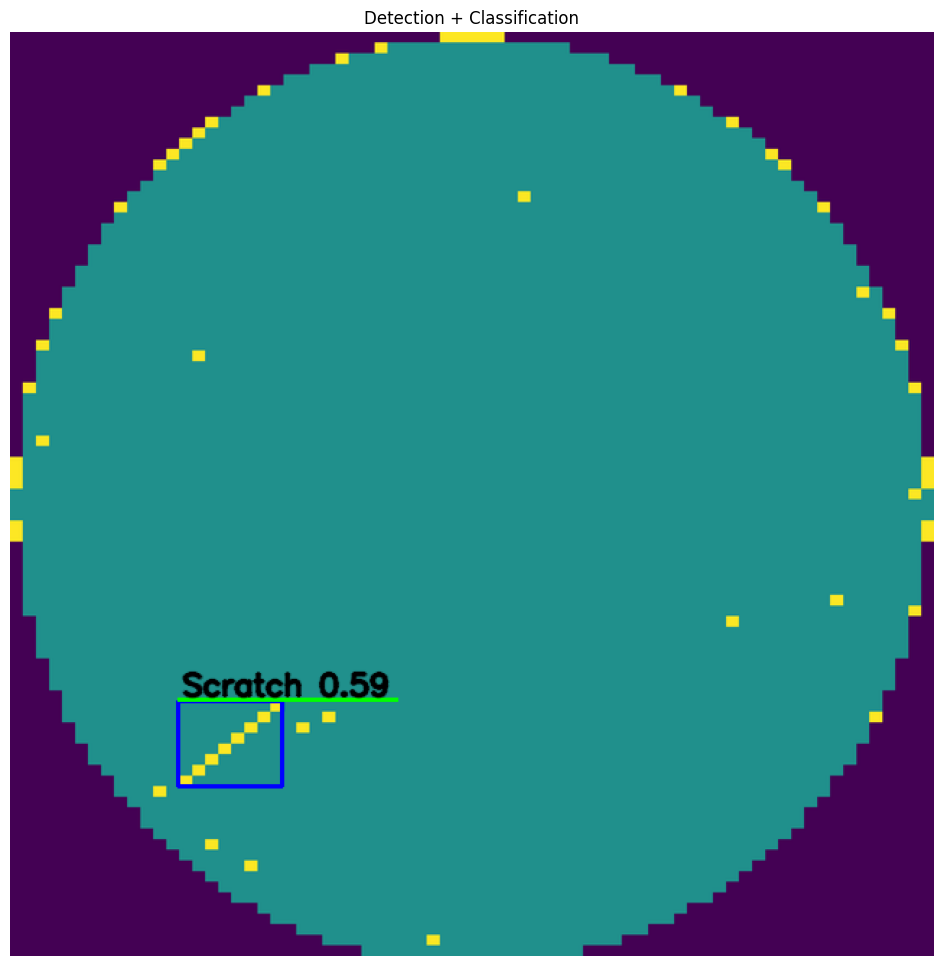

In [5]:
print("모델 및 필요 객체 로딩...")
yolo = YOLO(YOLO_MODEL_PATH)

clf = tf.keras.models.load_model(
    CLASSIFIER_MODEL_PATH,
    safe_mode=False,
    custom_objects={
        "Slice1D": Slice1D,
        "SafeLog1p": SafeLog1p,
        "RadialPos": RadialPos,
        "SectorAngle": SectorAngle,
        "Sin": Sin,
        "Cos": Cos,
    }
)
print("-> 분류 모델 로딩 완료.")

encoder = joblib.load(ENCODER_PATH)
print("-> 라벨 인코더 로딩 완료.")

dummy = [
    np.zeros((1,128,128,3), np.float32),
    np.zeros((1,10),        np.float32),
    np.zeros((1,1),         np.int32),
    np.zeros((1,1),         np.int32),
]
warm = clf([tf.convert_to_tensor(a) for a in dummy], training=False).numpy()
print("warmup out shape:", warm.shape, " sum:", warm.sum(), " max:", warm.max())

# 출력 차원-클래스 수 검증(선택)
n_out = clf.output_shape[-1]
assert n_out == len(encoder.classes_), f"모델 출력 {n_out} vs 레이블 {len(encoder.classes_)}"

# 실행
result = detect_and_classify_wafer(TEST_IMAGE_PATH, yolo, clf, encoder)


if result is not None:
    save_path = "result_Scratch1105.png"     # 저장 파일명
    cv2.imwrite(save_path, result)
    print(f"✅ 결과 저장: {save_path}")

    # 화면 표시(Windows/Colab 모두 안전)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,12))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis("off"); plt.title("최종 탐지")
    plt.show()
